In [1]:
#!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Importing libraries

In [110]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt

Loading MNIST dataset

In [111]:
## transformations
transform = transforms.ToTensor()

#transform = transforms.Compose([
#            transforms.ToTensor(),
#            transforms.Normalize((0.5), (0.5))                    
#])

## download and load training dataset
mnist_data = datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
## download and load training dataset
trainset = datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True)

## download and load testing dataset
testset = datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False)

Autoencoder Class

In [113]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
# Note : [-1, -1] -> nn.Tanh
# nn.MaxPool2d -> nn.MaxUnpool2d

In [120]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

Training Autoencoder model with denoized digits

In [121]:
def train(model, optimizer, loss_fn, train_dl, epochs=5, device='cpu'):
    noise_factor=0.5
    outputs = []
    for epoch in range(epochs):
        for (img, _) in train_dl:
            #img = img.reshape(-1, 28*28)  use for Autoencoder_Linear

            ## add random noise to the input images
            noisy_imgs = img + noise_factor * torch.randn(*img.shape)
            # Clip the images to be between 0 and 1
            noisy_imgs = np.clip(noisy_imgs, 0., 1.)

            recon = model(noisy_imgs) # reconstructed image
            loss = loss_fn(recon, img) # 

            optimizer.zero_grad() # do not forget about this step
            loss.backward()
            optimizer.step()

        print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
        outputs.append((epoch, img, recon))

In [123]:
train(model, optimizer, criterion, trainloader)

Epoch:1, Loss:0.0248
Epoch:2, Loss:0.0155
Epoch:3, Loss:0.0151
Epoch:4, Loss:0.0123
Epoch:5, Loss:0.0121


Testing the trained autoencoder model 

In [124]:
def inference(model, testloader):
    # obtain one batch of test images
    noise_factor=0.5
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # add noise to the test images
    noisy_imgs = images + noise_factor * torch.randn(*images.shape)
    noisy_imgs = np.clip(noisy_imgs, 0., 1.)

    # get sample outputs
    output = model(noisy_imgs)
    # prep images for display
    noisy_imgs = noisy_imgs.numpy()

    # output is resized into a batch of iages
    output = output.view(64, 1, 28, 28)
    # use detach when it's an output that requires_grad
    output = output.detach().numpy()

    '''# plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

    # input images on top row, reconstructions on bottom
    for noisy_imgs, row in zip([noisy_imgs, output], axes):
        for img, ax in zip(noisy_imgs, row):
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)'''

    #plot the first ten input image and then reconstructed images

    img = np.squeeze(noisy_imgs[0])
    fig = plt.figure(figsize = (5,5)) 
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')

    img2 = np.squeeze(output[0])
    fig = plt.figure(figsize = (5,5)) 
    ax = fig.add_subplot(111)
    ax.imshow(img2, cmap='gray')
    
    

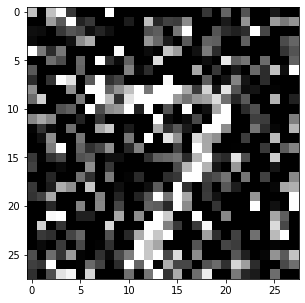

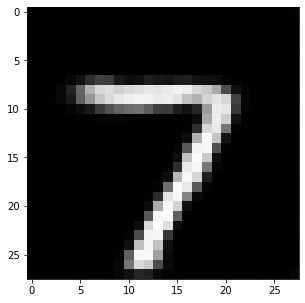

In [125]:
inference(model, testloader)

Classification network and eveluate efectiveness of the autoencoder

In [154]:
## transformations
transform = transforms.ToTensor()

#transform = transforms.Compose([
#            transforms.ToTensor(),
#            transforms.Normalize((0.5), (0.5))                    
#])

## download and load training dataset
mnist_data = datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
## download and load training dataset
trainset = datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=20,
                                          shuffle=True)

## download and load testing dataset
testset = datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=20,
                                         shuffle=False)

Classification model 

In [131]:
class ClassifyModel(nn.Module):
    def __init__(self):
        super(ClassifyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [137]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_classify = ClassifyModel()
model_classify = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [133]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

Training classification model on clean train set

In [139]:
def train_classify(model_classify, optimizer, criterion, trainloader, num_epochs=5, device='cpu'):
    for epoch in range(num_epochs):
        train_running_loss = 0.0
        train_acc = 0.0

        model_classify = model_classify.train()

        ## training step
        for i, (images, labels) in enumerate(trainloader):
            
            images = images.to(device)
            labels = labels.to(device)

            logits = model_classify(images)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()

            ## update model params
            optimizer.step()

            train_running_loss += loss.detach().item()
            train_acc += get_accuracy(logits, labels, 20)
        
        model.eval()
        print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
              %(epoch, train_running_loss / i, train_acc/i))   

In [140]:
train_classify(model_classify, optimizer, criterion, trainloader)

Epoch: 0 | Loss: 1.4891 | Train Accuracy: 97.42
Epoch: 1 | Loss: 1.4805 | Train Accuracy: 98.22
Epoch: 2 | Loss: 1.4765 | Train Accuracy: 98.60
Epoch: 3 | Loss: 1.4750 | Train Accuracy: 98.72
Epoch: 4 | Loss: 1.4725 | Train Accuracy: 98.94


Testing a classification model on clean test set

In [143]:
def test_classify(model_classify, testloader):
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model_classify.eval() # prep model for training

    for data, target in testloader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_classify(data)
        # calculate the loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(20):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss/len(testloader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

In [144]:
test_classify(model_classify, testloader)

Test Loss: 1.481816

Test Accuracy of     0: 97% (959/980)
Test Accuracy of     1: 99% (1130/1135)
Test Accuracy of     2: 97% (1006/1032)
Test Accuracy of     3: 99% (1001/1010)
Test Accuracy of     4: 97% (962/982)
Test Accuracy of     5: 97% (868/892)
Test Accuracy of     6: 98% (940/958)
Test Accuracy of     7: 98% (1012/1028)
Test Accuracy of     8: 94% (925/974)
Test Accuracy of     9: 97% (986/1009)

Test Accuracy (Overall): 97% (9789/10000)


Testing a classification model on noisy test set

In [147]:
def test_noisy(model_classify, testloader):
    # initialize lists to monitor test loss and accuracy
    noise_factor=0.5
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model_classify.eval() # prep model for training

    for data, target in testloader:
        
        # add noise to the test images
        noisy_imgs = data + noise_factor * torch.randn(*data.shape)
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)

        # get sample outputs
        output = model_classify(noisy_imgs)
      

        # forward pass: compute predicted outputs by passing inputs to the model
      
        # calculate the loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(20):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss/len(testloader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

In [148]:
test_noisy(model_classify, testloader)

Test Loss: 1.692330

Test Accuracy of     0: 56% (550/980)
Test Accuracy of     1: 73% (838/1135)
Test Accuracy of     2: 88% (914/1032)
Test Accuracy of     3: 78% (790/1010)
Test Accuracy of     4: 94% (927/982)
Test Accuracy of     5: 90% (807/892)
Test Accuracy of     6: 85% (815/958)
Test Accuracy of     7: 70% (726/1028)
Test Accuracy of     8: 78% (765/974)
Test Accuracy of     9: 56% (574/1009)

Test Accuracy (Overall): 77% (7706/10000)
